Harman Ransi <br>
4/6/24 <br>
Big Data Tools <br>
Final Project
___

# **Fetching Data Live From Redis**

\- In the real world, data is changing all the time <br>
\- Data Scientists need to fetch most current data when modeling <br>
\- RedisDB has function to return all current data as a df <br>
\- As data changes dat be day, data scientists can use function to get most current data, and build the best models possible

In [ ]:
import sys
sys.path.insert(0, '../RedisDB')
from RedisDB import RedisDB

# Create an instance of the RedisDB class
redis_db = RedisDB(config_file='../RedisDB/config.yaml')

In [ ]:
# fetching data for modeling purposes
df = redis_db.redis_data_to_dataframe()

# **XGBoost**

\- Why?... XGBoost is great w/ structured classification tasks (boosted decision trees) <br>
\- Extra Benefits?... tells us feature importance

## *XGBoost Model 1*

\- Generic XGBoost with good accuracy, but too many False Positives <br>
\- Data Flaws... heavy class imbalance (only a few positives for Heart Disease) <br>
\- Solution... Use SMOTE to synthetically make more positive readings, weight positive class heavier

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the original dataset
df = pd.read_csv('/content/drive/MyDrive/CS Foundation Courses/1) Spring 2024/Big Data Tools/Project/redis_data.csv')

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert categorical variables to one-hot encoding
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Convert target variable to numerical values
y_train_encoded = y_train.map({'Yes': 1, 'No': 0})
y_test_encoded = y_test.map({'Yes': 1, 'No': 0})

# Initialize and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_encoded, y_train_encoded)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)




Accuracy: 0.9162588533279132

Confusion Matrix:
[[58046   470]
 [ 4886   557]]


## *XGBoost Model 2*

\- only 5% lower accuracy, but much less False Positives <br>
\- solved by using SMOTE on positive class and also weighting instances heavier <br>
\- Will do a better job at accurately portraying feature importance for Heart Disease <br>


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load the original dataset
df = pd.read_csv('/content/drive/MyDrive/CS Foundation Courses/1) Spring 2024/Big Data Tools/Project/redis_data.csv')

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Convert categorical variables to one-hot encoding
X_encoded = pd.get_dummies(X)

# Convert target variable to numerical values
y_encoded = y.map({'Yes': 1, 'No': 0})

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Apply SMOTE to the training data only
smote = SMOTE(sampling_strategy={1: 130000}, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize and train the XGBoost classifier with increased weight for the positive class
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=3.5)
xgb_classifier.fit(X_train_smote, y_train_smote)

# Make predictions on the original test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.8417267311871668

Confusion Matrix:
[[50766  7750]
 [ 2373  3070]]


## *Analysis of XGBoost Model 2*

\- *bad lifestyle habits*, *age*, *diabetes* and *stroke* seem to be strong predictors <br>
\- i.e. smoking=no... probably associated with no heart disease, stroke=yes...probably associate with heart disease<br>

In [ ]:
# Get feature importances from the trained model
feature_importances = xgb_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top most important features
feature_importance_df['Rank'] = range(1, len(feature_importance_df) + 1)

# Display the top most important features with their ranks
top_10_features = feature_importance_df
print("Top most important features:")
top_10_features.head(15)



Top most important features:


,Feature,Importance,Rank
4,Smoking_No,0.066646,1
11,DiffWalking_Yes,0.052194,2
25,AgeCategory_75-79,0.050911,3
9,Stroke_Yes,0.041451,4
35,Diabetic_Yes,0.041439,5
42,GenHealth_Poor,0.039984,6
40,GenHealth_Fair,0.039339,7
26,AgeCategory_80 or older,0.039197,8
13,Sex_Male,0.034697,9
5,Smoking_Yes,0.034472,10


# **Logistic Regression Model**

\- Why?... LogReg is also good with structued classification tasks <br>
\- Extra Benefits... eigenvalues tell us importance of variable <br>
\- i.e. tells us importance of "smoking" variable as a whole (not just "smoking_no")

## *LogReg Model 1*

\- used SMOTE again, logreg handles class imbalance well, but to be safe <br>
\- 78% accuracy, similar results to XGBoost model <br>
\- advantage... eigenvals tell us variable importance <br>

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder

# Load the original dataset
df = pd.read_csv('/content/drive/MyDrive/CS Foundation Courses/1) Spring 2024/Big Data Tools/Project/redis_data.csv')

# Split the data into features (X) and target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Create a LabelEncoder object
le = LabelEncoder()

# Loop over each column in X
for col in X.columns:
    # Only encode columns with object datatype
    if X[col].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        X[col] = le.fit_transform(X[col])

# Encode the target variable
y = le.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SMOTE instance
smote = SMOTE(sampling_strategy={1: 130000}, random_state=42)

# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize the Logistic Regression model with class weight
model = LogisticRegression(class_weight={1: 1.2}, max_iter=1000)

# Fit the model to the SMOTE training data
model.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix:')
print(cm)


Accuracy: 0.7814537438046248
Confusion Matrix:
[[46813 11703]
 [ 2275  3168]]


## *Analysis of LogReg Model 1*

\- eigenvals tell us importance of each variable on target <br>
\- lines up with most of the factors in the xgboost model <br>
\- only big difference is sex being a big factor <br>
\- ^ scientific research suggests this is a big factor, so this is a good sign

In [20]:
from tabulate import tabulate

# Transpose the DataFrame for easier manipulation
coef_df_transposed = coef_df.transpose()

# Reset the index to get the features as a column
coef_df_transposed.reset_index(inplace=True)

# Rename the columns
coef_df_transposed.columns = ['Feature', 'Coefficient']

# Sort the DataFrame by the coefficient value in descending order
coef_df_transposed.sort_values(by='Coefficient', ascending=False, inplace=True)

# Print the DataFrame using tabulate
print(tabulate(coef_df_transposed, headers='keys', tablefmt='psql', showindex=False))



+------------------+---------------+
| Feature          |   Coefficient |
|------------------+---------------|
| Sex              |     0.331262  |
| Stroke           |     0.321945  |
| AgeCategory      |     0.31425   |
| Diabetic         |     0.272728  |
| Smoking          |     0.133424  |
| PhysicalHealth   |     0.0393398 |
| Race             |     0.0238475 |
| BMI              |     0.0236575 |
| MentalHealth     |     0.0156266 |
| SleepTime        |    -0.0384139 |
| GenHealth        |    -0.103812  |
| DiffWalking      |    -0.302903  |
| KidneyDisease    |    -0.312027  |
| SkinCancer       |    -0.461199  |
| Asthma           |    -0.617405  |
| PhysicalActivity |    -0.704137  |
| AlcoholDrinking  |    -1.61587   |
+------------------+---------------+


# **Visual of Data - Correlation Heatmap of RECENT DATA**

\- To see how things shift, look @ REAL DAT

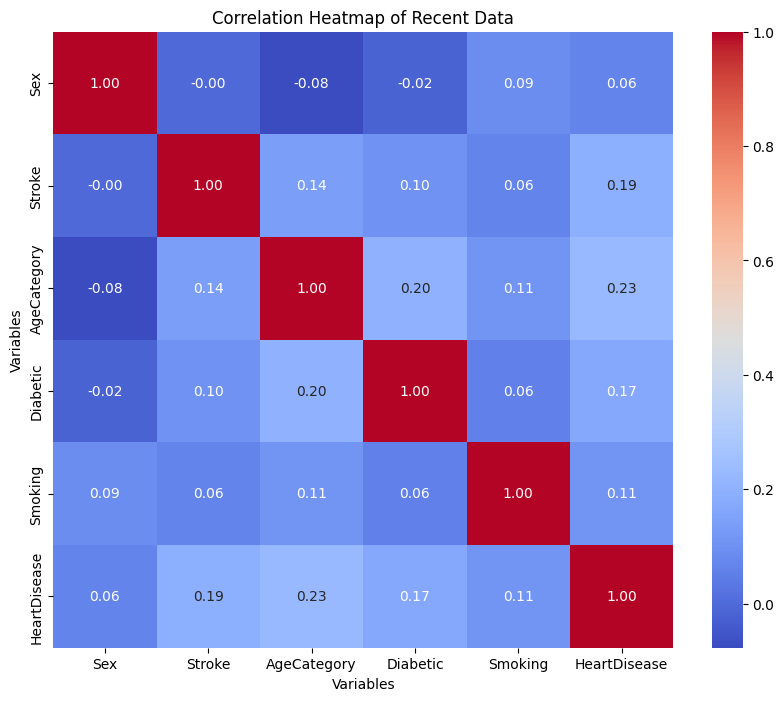

<Axes: title={'center': 'Correlation Heatmap of Recent Data'}, xlabel='Variables', ylabel='Variables'>

In [1]:
import sys
sys.path.insert(0, '../RedisDB')
from RedisDB import RedisDB

# Create an instance of the RedisDB class
redis_db = RedisDB(config_file='../RedisDB/config.yaml')
redis_db.heatmap_using_recent_data()